In [5]:
import nomic
import json
import os
import pickle

api_key_path = "/home/paperspace/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer
import torch

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc


dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')
bill_meta = pickle.load(open('bill_meta.p', 'rb'))

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent

df.head()

2024-10-30 22:14:46.670 | INFO     | nomic.dataset:__init__:761 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-30 22:14:47.543 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-30 22:14:47.544 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 10384.73it/s]
2024-10-30 22:14:48.162 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 185.03it/s]
2024-10-30 22:14:52.703 | INFO     | nomic.data_operations:_download_latent:550 - Downloading latent embeddings
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 10158.94it/s]
2024-10-30 

tweetId                postedAt                 name state  \
0  1065633444502224896 2018-11-22 15:49:46.338        Ken Buck R-CO    CO   
1  1479108462504136704 2022-01-06 15:11:52.624     Kat Cammack R-FL    FL   
2    85108215381102592 2011-06-26 22:12:34.438     Dennis Ross R-FL    FL   
3   925691081026621440 2017-11-01 11:48:46.882  Richard Hudson R-NC    NC   
4  1435963943533568000 2021-09-09 13:50:57.715        Chip Roy R-TX    TX   

  party  twitter_lower chamber      years      source       id  \
0     R     repkenbuck   House  2017_2018  PolitWoops  1203633   
1     R  repkatcammack   House  2021_2022  PolitWoops  2857207   
2     R  repdennisross   House  2011_2012  PolitWoops    35353   
3     R  reprichhudson   House  2017_2018  PolitWoops   954870   
4     R     repchiproy   House  2021_2022  PolitWoops  2324693   

                                                text  
0  Happy #Thanksgiving! I hope everyone has a cha...  
1  RT @MorningsMaria: .@RepKatCammack: "The Democ...  
2         @CEP_Observer will have to check that out.  
3  RT @BGClubCab: Thanks to @CharlotteWBB for hel...  
4         RT @chiproytx: No. https://t.co/STZW0DdDz1

In [6]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [7]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
<All keys matched successfully>


In [8]:
#- Should be able to re-factor so that we are not keeping n_bills copies of embeddings / text

congress_name_list= list(df['name'].unique())   
n_congresspersons = len(congress_name_list)

name_to_standardized_name = {}

for name in congress_name_list:
    chunks = name.lower().split(' ')[:2]
    if ',' in chunks[0]:
        standardized_name = chunks[1] + '_' + chunks[0][:-1]
    else:
        standardized_name = chunks[0] + '_' + chunks[1]

    name_to_standardized_name[name] = unidecode(standardized_name)
standardized_name_list = list(name_to_standardized_name.values())
    
standardize_vote = {
    'Yea': 'yea', 
    'Aye': 'yea', 
    'Nay': 'nay', 
    'No': 'nay', 
    'Not Voting': 'not voting',
    'Present': 'not voting'
    }
    
cp_metadata_by_bill = {}
text_dict = {}
embd_dict = {}
for bill in bill_meta:
    cp_metadata_by_bill[bill] = {}
    
    if bill_meta[bill]['house_vote_id'] == '':
        HOUSE = False
        congress_name_list_house = []
    else:
        HOUSE = True
        
    if bill_meta[bill]['senate_vote_id'] == '':
        SENATE = False
        congress_name_list_senate = []
        
    else:
        SENATE = True
    
    
    if HOUSE:
        year, month, day = bill_meta[bill]['house_vote_date'].split('-')
        house_t = pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        house_vote_id = bill_meta[bill]['house_vote_id']
        
        df_house = pd.read_csv(f'/home/paperspace/congressional-twin/data/data/{house_vote_id}.csv', header=0)
        congress_name_list_house = df_house['matched-name'].unique()
        congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]
        
        
    if SENATE:
        year, month, day = bill_meta[bill]['senate_vote_date'].split('-')
        senate_t =  pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        senate_vote_id = bill_meta[bill]['senate_vote_id']
    
        df_senate = pd.read_csv(f'/home/paperspace/congressional-twin/data/data/{senate_vote_id}.csv', header=0)
        congress_name_list_senate = df_senate['matched-name'].unique()
        congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]

    t_dict = {'house': house_t, 'senate': senate_t}
    
    #- Add all congress persons in Atlas dataframe to name_to_standardized_name
    for name in congress_name_list:
        party=df[df['name'] == name]['party'].values[0].lower()
        
        if name in congress_name_list_house:
            vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
            chamber='house'
        elif name in congress_name_list_senate:
            vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
            chamber='senate'
        else:
            vote='n/a'
            chamber=df[df['name'] == name]['chamber'].values[0].lower()
        
        standardized_name = name_to_standardized_name[name]
                    
        cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

    text_dict[bill] = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
    embd_dict[bill] = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

    
#- this could be way faster
for i, embd in enumerate(tqdm(embds)):
    name = df['name'][i]
    posted_at = df['postedAt'][i]
    party = df['party'][i].lower()
    chamber = df['chamber'][i].lower()
    
    standardized_name = name_to_standardized_name[name]
    
    for bill in cp_metadata_by_bill:
        if standardized_name not in cp_metadata_by_bill[bill]:
            vote = 'n/a'
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

        if posted_at > t_dict[chamber]:
            key='post-t'
        else:
            key='pre-t'

        text_dict[bill][standardized_name][key].append(df['text'][i])
        embd_dict[bill][standardized_name][key].append(embd)

for bill in cp_metadata_by_bill:
    for name in standardized_name_list:
        embd_dict[bill][standardized_name]['post-t'] = np.array(embd_dict[bill][standardized_name]['post-t'])
        embd_dict[bill][standardized_name]['pre-t'] = np.array(embd_dict[bill][standardized_name]['pre-t'])

    embedded_questions = []
    for i,question in enumerate(bill_meta[bill]['questions']):
        question = 'search_query: ' + question
        embedded_questions.append(question)

    bill_meta[bill]['embedded_questions'] = embedding_model.encode(embedded_questions)

100%|██████████████████████████████████████████████████████████████████████| 3214913/3214913 [04:27<00:00, 12022.70it/s]


In [9]:
import pickle
np.random.seed(1)

timeframes = ['pre-t', 'post-t']
if os.path.exists('inference_sampled_tweets_by_bill_semantic_search.p'):
    sampled_tweets_by_bill = pickle.load(open('inference_sampled_tweets_by_bill_semantic_search.p', 'rb'))
else:
    sampled_tweets_by_bill = {}

n_cps = 500
for bill in cp_metadata_by_bill:
    if bill in sampled_tweets_by_bill:
        continue
        
    sampled_tweets_by_bill[bill] = {}
    questions = bill_meta[bill]['questions']
    
    name = 'morgan_griffith'
    sampled_tweets_by_bill[bill][name] = {
        'retrieved': {q: [] for q in questions}, 
        'generated': {q: [] for q in questions},
    }

    shuffled_cps = np.random.choice(standardized_name_list, len(standardized_name_list), replace=False)    
    for name in shuffled_cps:
        #- only consider n_cps congresspersons
        if len(sampled_tweets_by_bill[bill]) >= n_cps:
            break

        if name in sampled_tweets_by_bill[bill]:
            continue

        try:
            proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
            proper=True
        except:
            proper=False

        if not proper:
            continue
            
        #- only consider congresspersons with enough tweets after t
        if len(text_dict[bill][name]['pre-t']) == 0:
            continue
            
 
        sampled_tweets_by_bill[bill][name] = {
            'retrieved': {q: [] for q in questions}, 
            'generated': {q: [] for q in questions},
        }
        
    del bill, name, questions, proper

In [10]:
terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id
pipeline.tokenizer.padding_side = 'left'

for bill in cp_metadata_by_bill:
    print(bill)
    questions = bill_meta[bill]['questions']
    embedded_questions = bill_meta[bill]['embedded_questions']
    for name in tqdm(sampled_tweets_by_bill[bill]):
        if len(sampled_tweets_by_bill[bill][name]['generated'][questions[0]]) > 0:
            continue
        
        proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
        system_prompt = f"You are U.S. congressperson {proper_noun_name}."

        retrieved_tweet_indices = np.argmax(embd_dict[bill][name]['pre-t'] @ embedded_questions.T, axis=0)

        message_list = []
        for i,question in enumerate(questions):
            if len(sampled_tweets_by_bill[bill][name]['generated'][question]) > 0:
                already_done = True
                break
            else:
                already_done = False


            retrieved_tweet = text_dict[bill][name]['pre-t'][retrieved_tweet_indices[i]]
            sampled_tweets_by_bill[bill][name]['retrieved'][question] = retrieved_tweet

            user_prompt = f'Write a Tweet that addresses the following question: "{question}".'
            user_prompt += f' Here is an example Tweet potentially related to the to-be-completed Tweet: "{retrieved_tweet}".'
            user_prompt += ' Start your response with "Here is the full Tweet:".'

            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]

            message_list.append(messages)

        if not already_done:
            outputs = pipeline(
                message_list,
                batch_size=50,
                max_new_tokens=64,
                eos_token_id=terminators,
                do_sample=True,
                temperature=1,
                num_return_sequences=5
            )

            for i,question in enumerate(questions):
                temp_outputs=outputs[i]
                sampled_tweets_by_bill[bill][name]['generated'][question] = [o["generated_text"][-1]['content'] for o in temp_outputs]
                sampled_tweets_by_bill[bill][name]['generated'][question] = [t.split('Here is the full Tweet:')[-1].strip() for t in sampled_tweets_by_bill[bill][name]['generated'][question]]
                sampled_tweets_by_bill[bill][name]['generated'][question] = [remove_quotes(t) for t in sampled_tweets_by_bill[bill][name]['generated'][question] if len(t) > 0]

117-HR-1319


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 976327.75it/s]


117-HR-4346


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 849393.28it/s]


118-HR-347


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1111368.31it/s]


118-HR-1435


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1188861.68it/s]


118-HR-4639


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1116694.36it/s]


118-HR-7888


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 776435.39it/s]


118-HR-8035


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1152914.79it/s]


118-HR-8038


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1134822.51it/s]


118-HR-6090


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1125081.55it/s]


118-HR-3746


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1111957.58it/s]


118-HR-8282


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1197688.18it/s]


118-HR-8772


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1083799.48it/s]


118-HR-5717


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1121471.66it/s]


In [7]:
pickle.dump(sampled_tweets_by_bill, open(f'inference_sampled_tweets_by_bill_semantic_search.p', 'wb'))

In [11]:
try:
    pipline.model.to('cpu')
    embedding_model.to('cpu')
    del pipeline, embedding_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass
    
import pickle

sampled_tweets_by_bill = pickle.load(open(f'inference_sampled_tweets_by_bill_semantic_search.p', 'rb'))
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [12]:
_sampled_tweets_by_bill = {}

for bill in bill_meta:
    questions=bill_meta[bill]['questions']
    for name in sampled_tweets_by_bill[bill]:
        empty = False
        for type_ in sampled_tweets_by_bill[bill][name]:
            for question in questions:
                if len(sampled_tweets_by_bill[bill][name][type_][question]) == 0:
                    empty=True
        if not empty:
            _sampled_tweets_by_bill[name] = sampled_tweets_by_bill[bill][name].copy()
sampled_tweet_dict=_sampled_tweets_by_bill.copy()

In [13]:
filtered_tweets_by_bill = {}
for bill in bill_meta:
    filtered_tweets_by_bill[bill] = {}
    questions=bill_meta[bill]['questions']
    for name in sampled_tweets_by_bill[bill]:
        filtered_tweets_by_bill[bill][name] = {}
        for type_ in sampled_tweets_by_bill[bill][name]:
            filtered_tweets_by_bill[bill][name][type_] = {}
            for question in sampled_tweets_by_bill[bill][name][type_]:
                temp = []
                for response in sampled_tweets_by_bill[bill][name][type_][question]:
                    if 'I cannot' not in response:
                        temp.append(response)
                filtered_tweets_by_bill[bill][name][type_][question] = temp

In [14]:
matrix_representations = {}

for bill in filtered_tweets_by_bill:
    matrix_representations[bill] = {}
    questions = bill_meta[bill]['questions']
    for name in filtered_tweets_by_bill[bill]:
        matrix_representations[bill][name] = {}

        matrix_representations[bill][name]['retrieved'] = list(filtered_tweets_by_bill[bill][name]['retrieved'].values())
        matrix_representations[bill][name]['retrieved'] = embedding_model.encode(matrix_representations[bill][name]['retrieved'])

        matrix_representations[bill][name]['generated'] = []
        
        for question in questions:
            temp = filtered_tweets_by_bill[bill][name]['generated'][question]

            if len(temp) == 0:
                matrix_representations[bill][name]['generated'].append([])
            else:
                temp = embedding_model.encode(temp)
                mean = np.mean(temp, axis=0)
                matrix_representations[bill][name]['generated'].append(mean)

In [16]:
for bill in matrix_representations:
    questions = bill_meta[bill]['questions']
    for i, question in enumerate(questions):
        question_average = []
        for name in filtered_tweets_by_bill[bill]:
            if len(matrix_representations[bill][name]['generated'][i]) != 0:
                question_average.append(matrix_representations[bill][name]['generated'][i])

        question_average = np.mean(question_average, axis=0)

        for name in filtered_tweets_by_bill[bill]:
            if len(matrix_representations[bill][name]['generated'][i]) == 0:
                matrix_representations[bill][name]['generated'][i] = question_average

In [17]:
dist_matrices = {}

for bill in matrix_representations:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
        
    name_list = list(matrix_representations[bill].keys())
    
    dist_matrix_retrieved = np.zeros((len(name_list), len(name_list)))
    dist_matrix_generated = np.zeros((len(name_list), len(name_list)))
    for i, name1 in enumerate(name_list):
        r1 = np.array(matrix_representations[bill][name1]['retrieved'])
        g1 = np.array(matrix_representations[bill][name1]['generated'])
        for ii, name2 in enumerate(name_list[i+1:], i+1):
            r2 = np.array(matrix_representations[bill][name2]['retrieved'])
            g2 = np.array(matrix_representations[bill][name2]['generated'])

            dist_matrix_retrieved[i, ii] = np.linalg.norm(r1-r2)
            dist_matrix_retrieved[ii, i] = dist_matrix_retrieved[i, ii]

            dist_matrix_generated[i, ii] = np.linalg.norm(g1-g2)
            dist_matrix_generated[ii, i] = dist_matrix_generated[i, ii]
    
    dist_matrices[bill] = {'retrieved': dist_matrix_retrieved, 'generated': dist_matrix_generated}

In [19]:
from graspologic.embed import ClassicalMDS

cmds_dict = {}

for bill in dist_matrices:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
        
    name_list = list(matrix_representations[bill].keys())
    cmds_dict[bill] = {}
    for type_ in dist_matrices[bill]:
        cmds_dict[bill][type_] = {}
        cmds = ClassicalMDS().fit_transform(dist_matrices[bill][type_])
        for i, name in enumerate(name_list):
            cmds_dict[bill][type_][name] = cmds[i]

pickle.dump(cmds_dict, open(f'cmds_dict_inference.p', 'wb'))

In [23]:
np.array(cmds_dict[bill]['retrieved'].values())

array(dict_values([array([-49.13038971,  58.66980336]), array([176.76185336, -24.50289667]), array([ -6.74592718, -17.39350624]), array([-63.60208027, -36.63228665]), array([ 38.25674641, -15.50908564]), array([24.96531949, 50.83754284]), array([-106.85357323,  -35.84929095]), array([-13.07237579,  -1.10623795]), array([-26.57546686,   4.25918659]), array([117.82112493, -36.91881248]), array([80.45005499,  1.6695757 ]), array([-23.6142775 , -22.12504258]), array([ 20.94092826, -35.58089211]), array([-15.13961929, -30.29631984]), array([ 38.89071145, -44.0261487 ]), array([ 21.37316478, -42.86634148]), array([-58.45018587,  20.7358286 ]), array([27.00096147, 13.92517659]), array([-28.67977495, -19.18126193]), array([-22.56051459,  -9.11367623]), array([133.24491992,  -8.58243488]), array([73.95862873, -2.75432953]), array([-0.35352959, 62.72831088]), array([-13.52179279,  22.05688905]), array([-14.0346074 , -19.85326326]), array([-28.48219315, -28.7324921 ]), array([ 85.48406725, -38.86

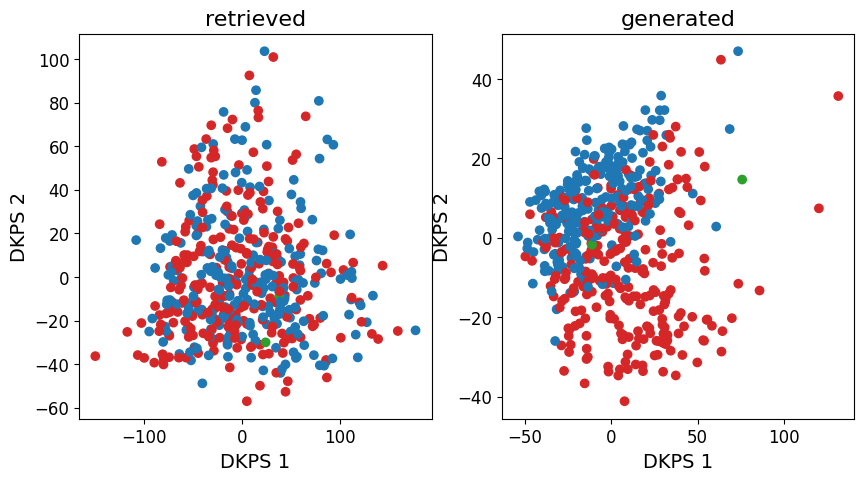

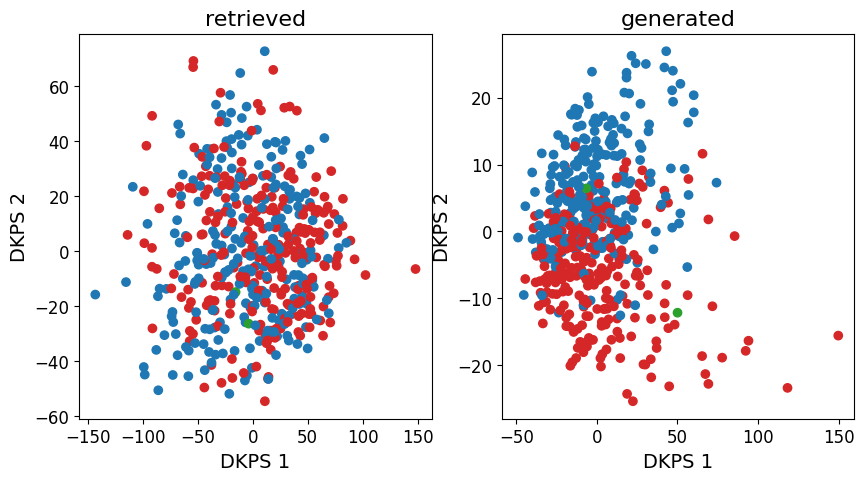

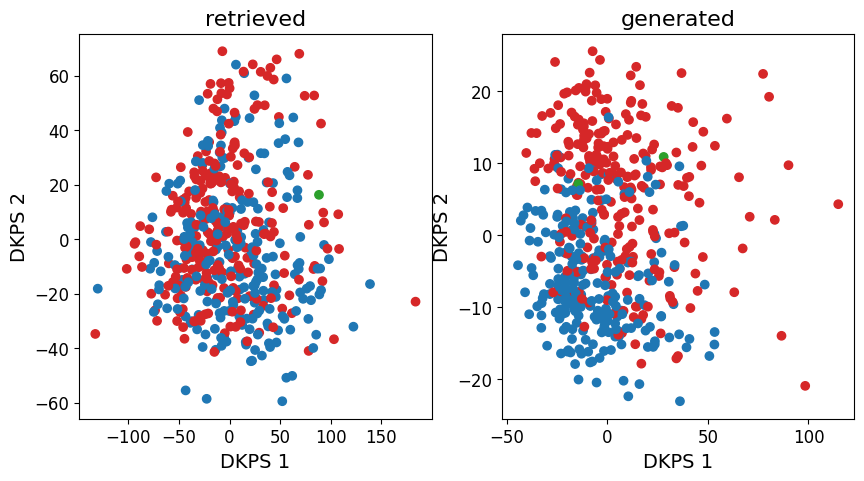

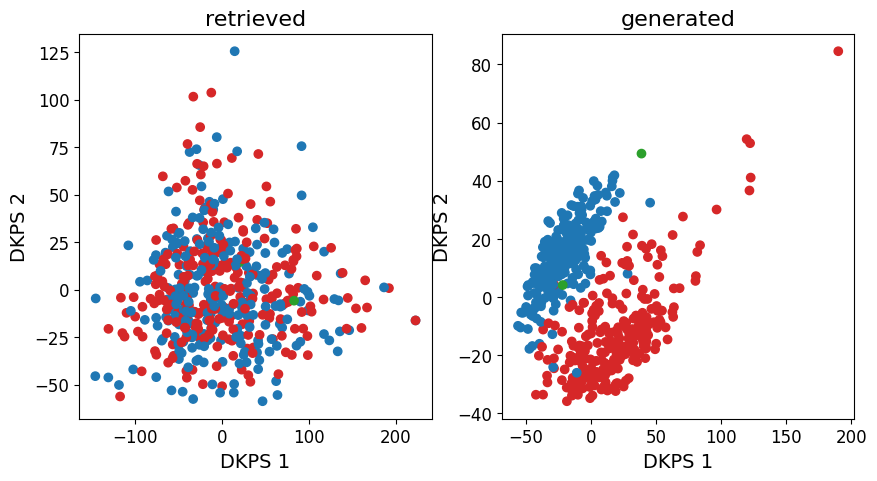

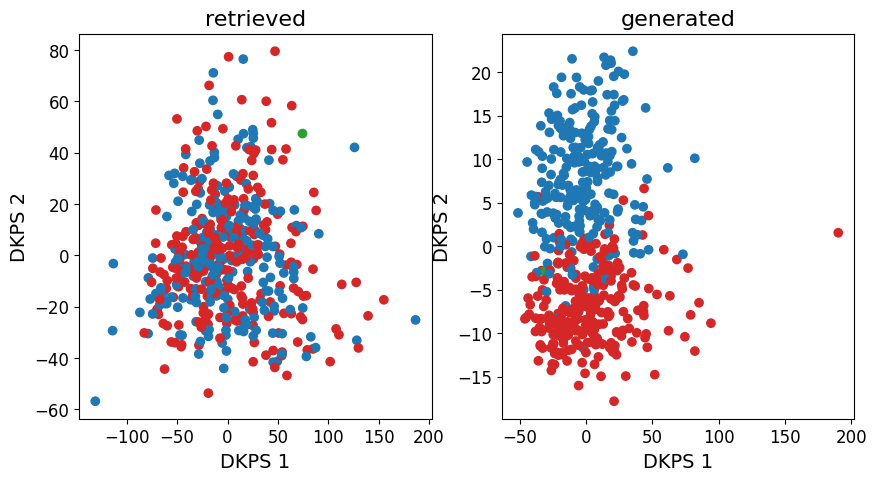

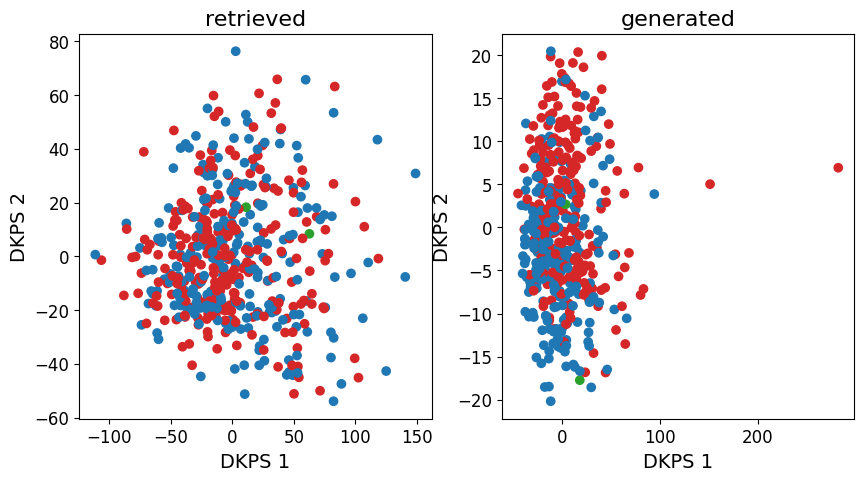

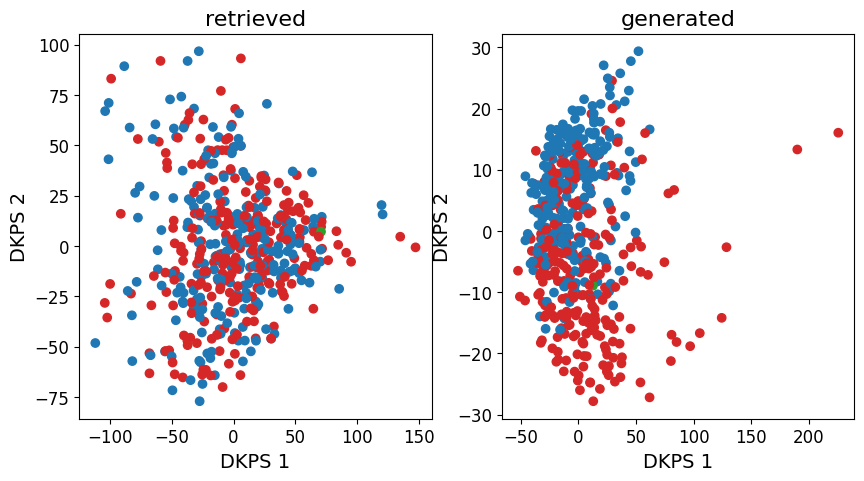

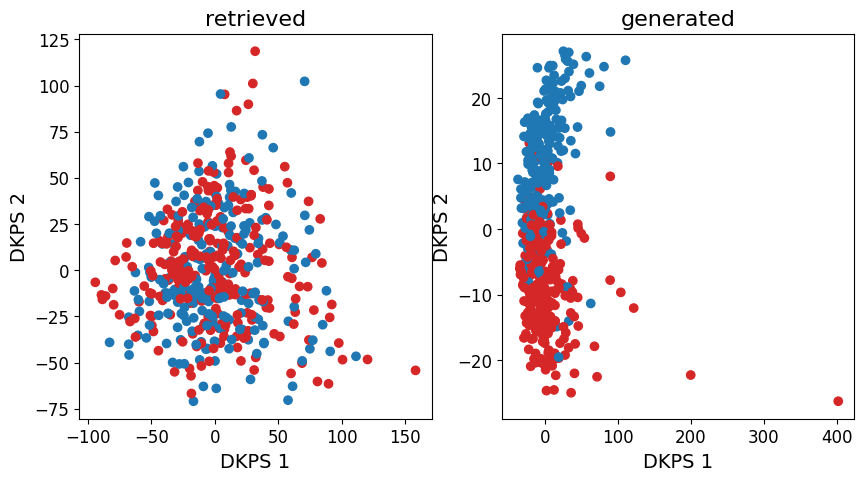

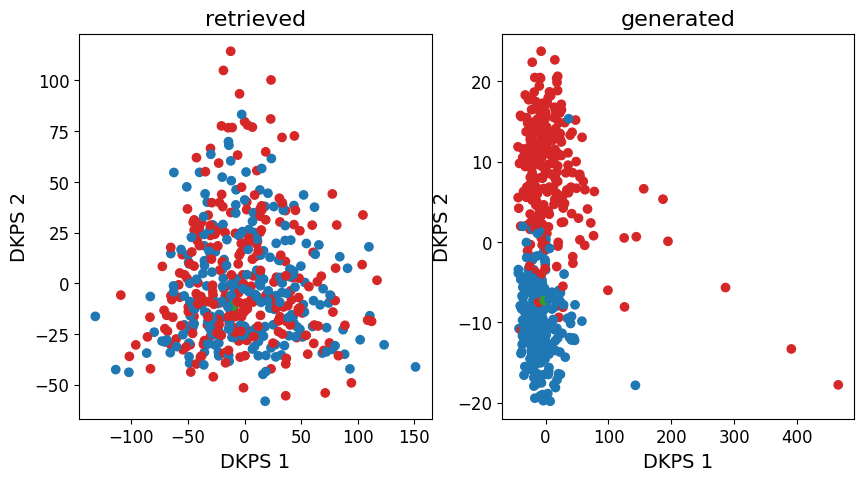

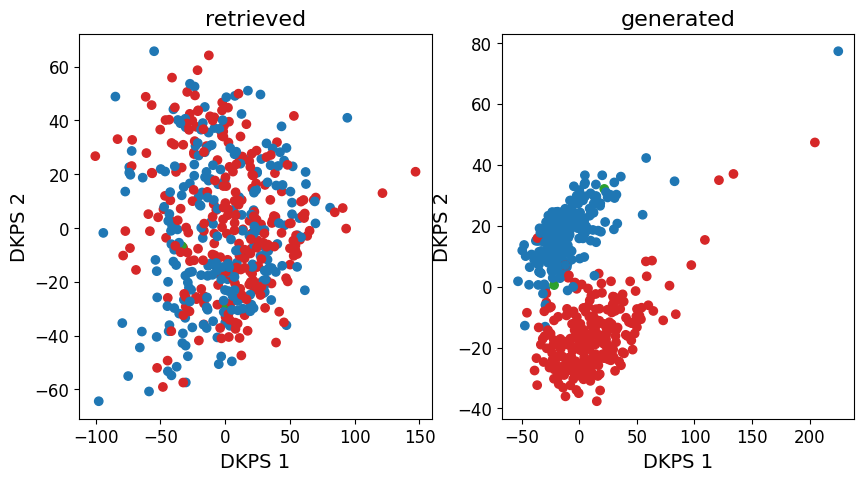

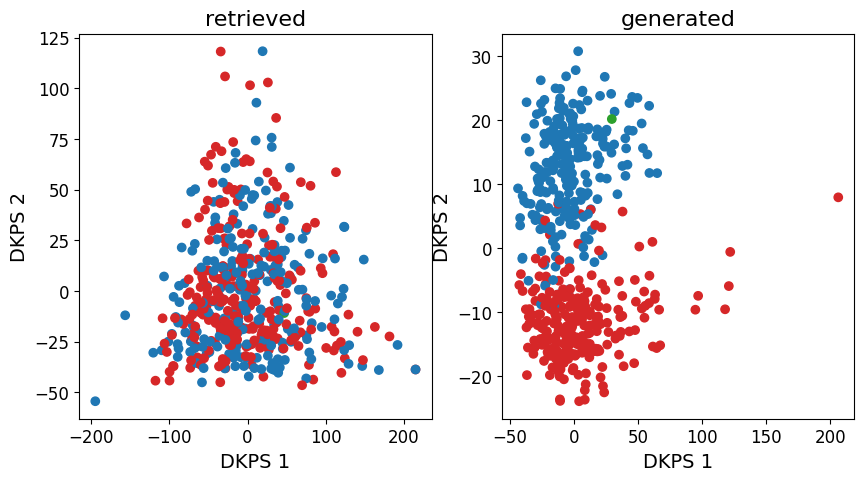

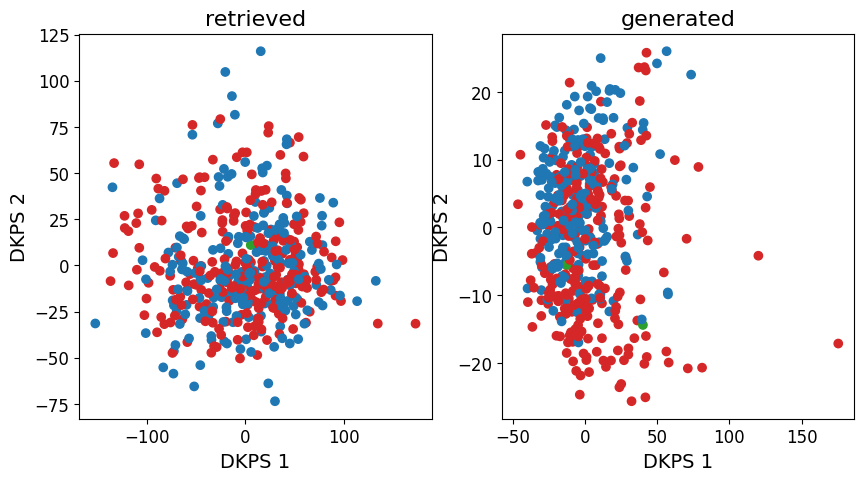

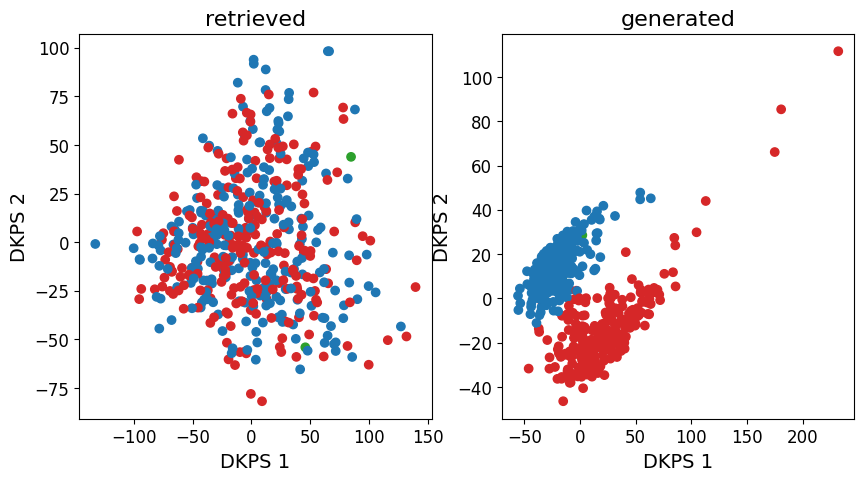

In [24]:
from graspologic.plot import pairplot, heatmap

party_color_dict = {'d': 'tab:blue', 'r': 'tab:red', 'i': 'tab:green', 'n/a': 'k'}
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'k'}

party_by_bill = {}
vote_by_bill = {}

for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    name_list = list(cmds_dict[bill][type_].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    party_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['party'] for name in name_list])
    vote_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['vote'] for name in name_list])
    
    party_list = party_by_bill[bill]

    axs[0].scatter(cmds_retrieved[:, 0], cmds_retrieved[:, 1], c=[party_color_dict[p] for p in party_list])
    axs[0].set_title('retrieved', fontsize=16)

    axs[1].scatter(cmds_generated[:, 0], cmds_generated[:, 1], c=[party_color_dict[p] for p in party_list])
    axs[1].set_title('generated', fontsize=16)

    for ax in axs:
        ax.tick_params(labelsize=12)
        ax.set_xlabel('DKPS 1', fontsize=14)
        ax.set_ylabel('DKPS 2', fontsize=14)

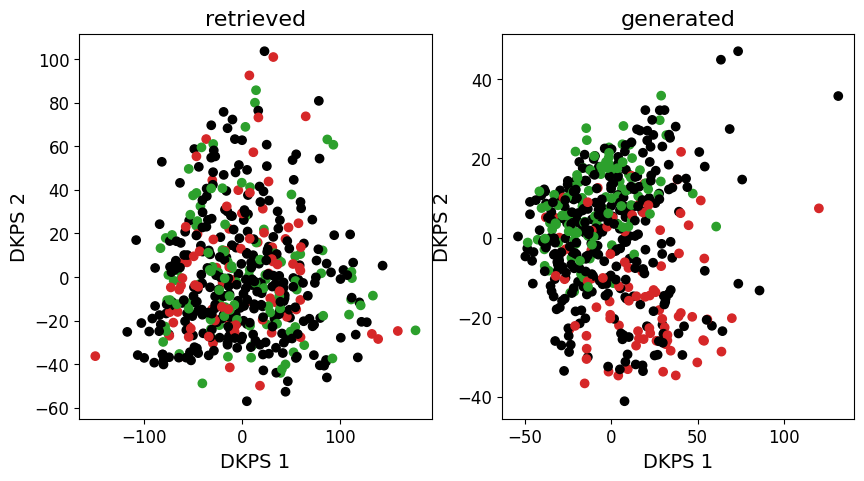

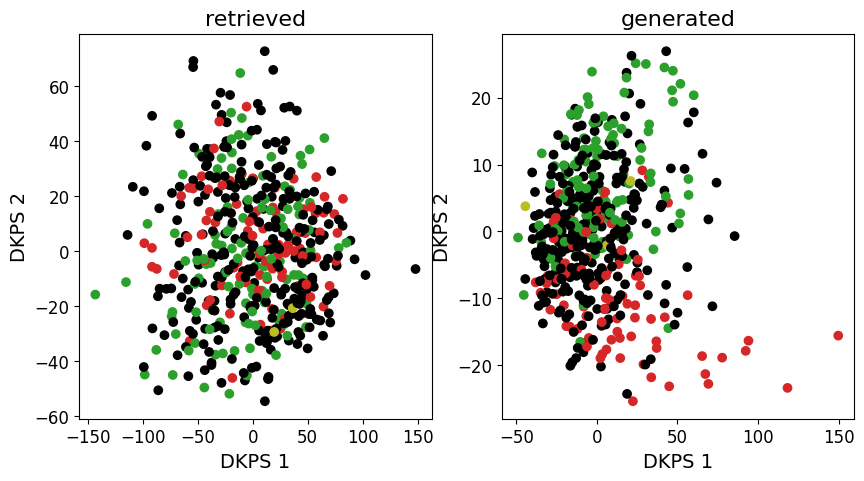

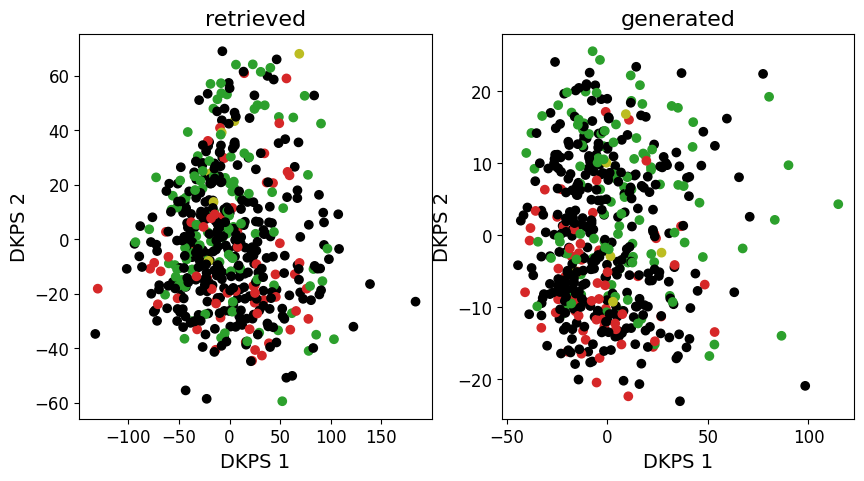

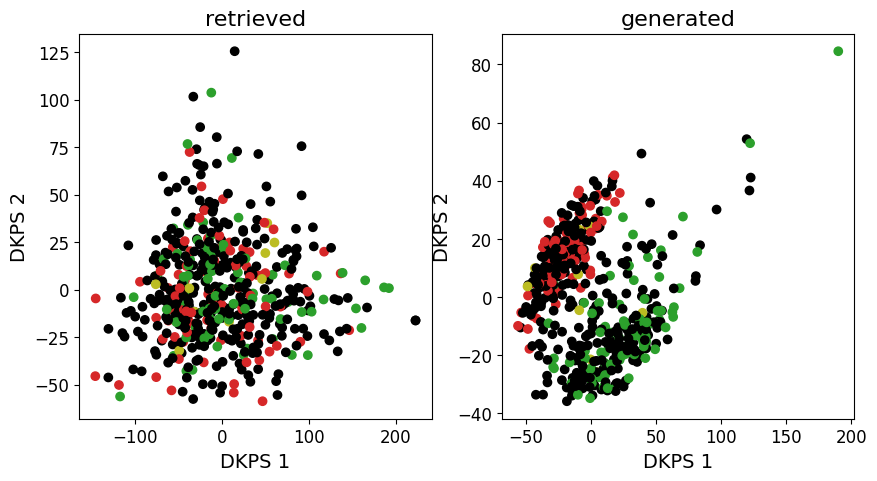

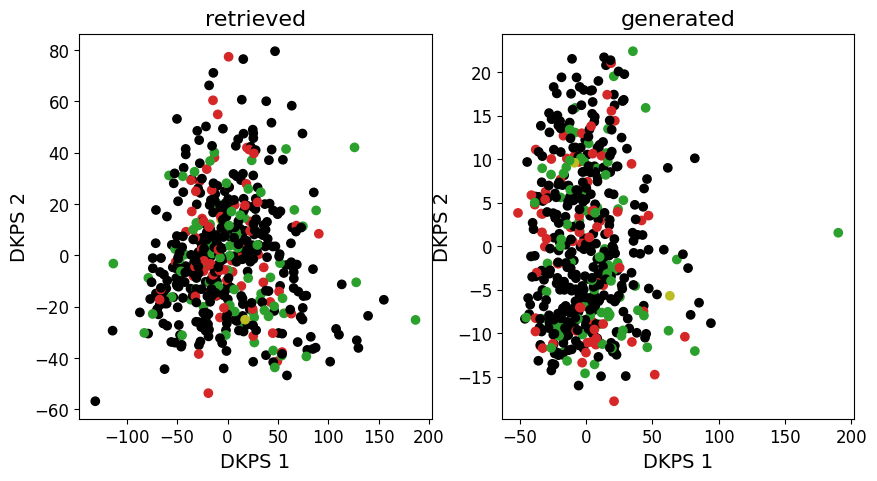

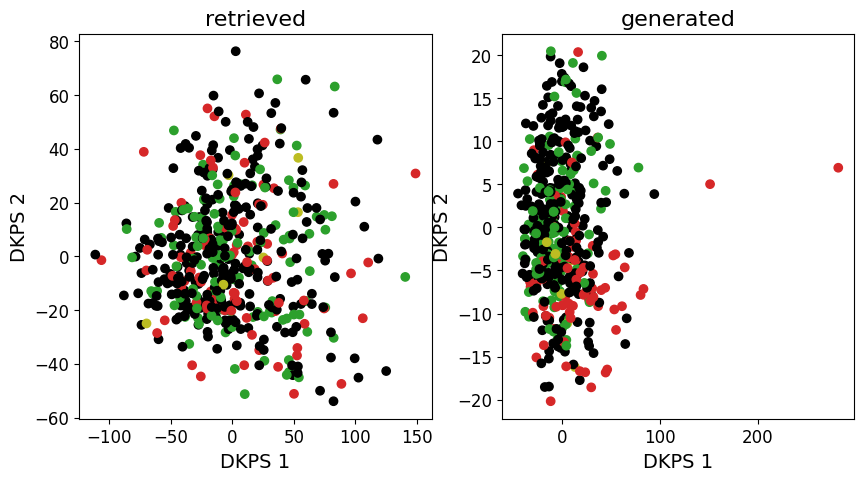

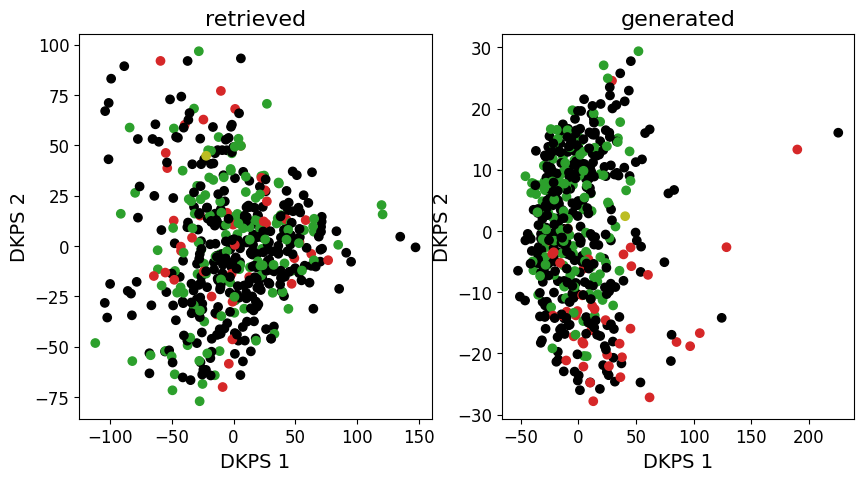

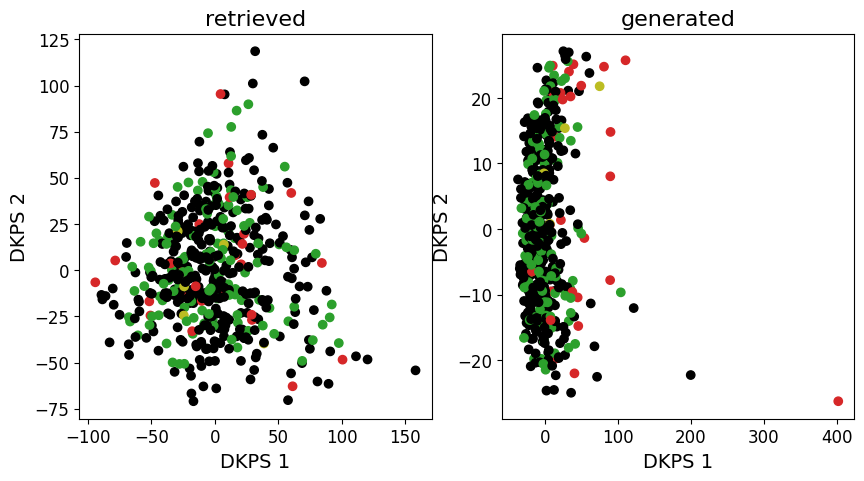

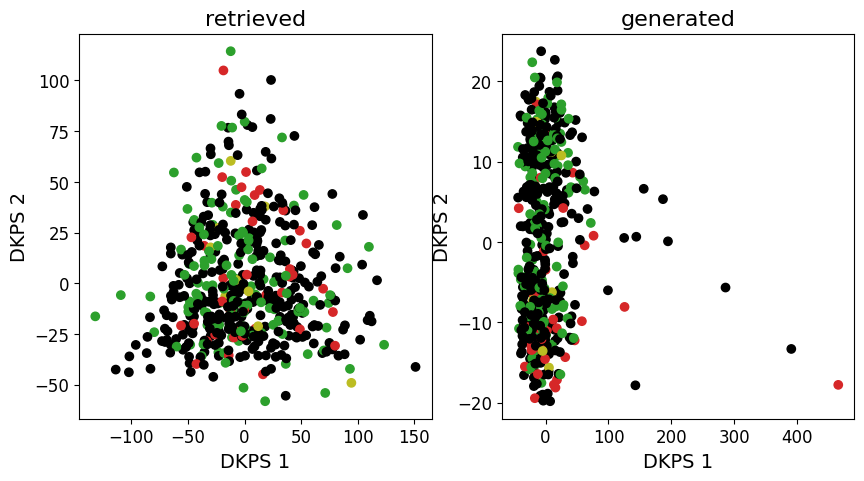

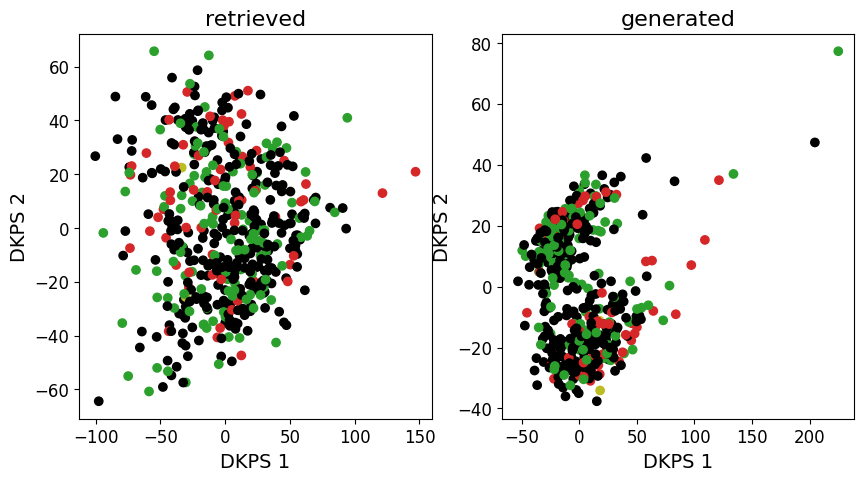

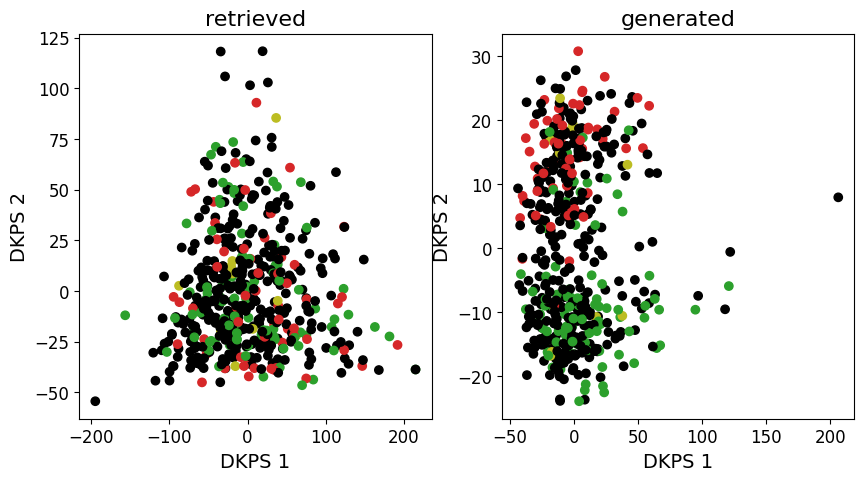

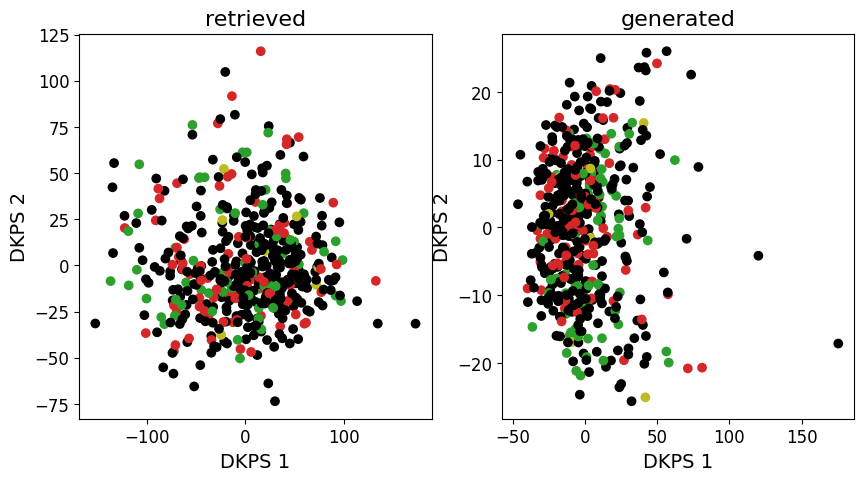

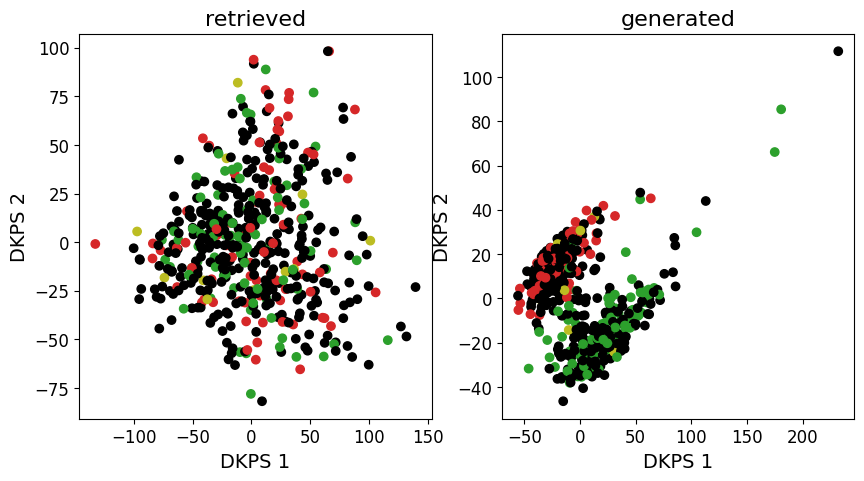

In [26]:
for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
        
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    vote_list = vote_by_bill[bill]
    
    name_list = list(cmds_dict[bill][type_].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    axs[0].scatter(cmds_retrieved[:, 0], cmds_retrieved[:, 1], c=[vote_color_dict[p] for p in vote_list])
    axs[0].set_title('retrieved', fontsize=16)

    axs[1].scatter(cmds_generated[:, 0], cmds_generated[:, 1], c=[vote_color_dict[p] for p in vote_list])
    axs[1].set_title('generated', fontsize=16)
    
    for ax in axs:
        ax.tick_params(labelsize=12)
        ax.set_xlabel('DKPS 1', fontsize=14)
        ax.set_ylabel('DKPS 2', fontsize=14)

In [29]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

score=accuracy_score

def get_indices_by_class(y):
    unique = np.unique(y)
            
    indices_by_class ={}
    for c in unique:
        indices_by_class[c] = np.where(y == c)[0]
        
    return indices_by_class

def get_stratified_folds(y, n_folds):
    indices_by_class = get_indices_by_class(y)
    folds = {i: {'train': [], 'test': []} for i in range(n_folds)}
        
    for c, indices in indices_by_class.items():
        test_per_fold = int(len(indices) *  (1 / n_folds))
        
        for i in range(n_folds):
            folds[i]['test']+= list(indices[i*test_per_fold: (i+1)*test_per_fold])
            
        
    for i in range(n_folds):
        folds[i]['train'] = np.array([j for j in range(len(y)) if j not in folds[i]['test']])
        folds[i]['test'] = np.array(folds[i]['test'])
        
    return folds

def get_stratified_sample(y, p):
    indices_by_class = get_indices_by_class(y)
    
    inds = []
    for c, indices in indices_by_class.items():
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict


n_folds=10
n_neighbors_list = [1,3,5,9,19]

best_score_generated = {}
argbest_score_generated = {}
std_best_generated = {}

best_score_retrieved = {}
argbest_score_retrieved = {}
std_best_retrieved = {}

std_results_dict = {}
average_results_dict = {}

for bill in cp_metadata_by_bill:
    if bill_meta[bill]['house_vote_id'] == '':
        continue

    average_results_dict[bill] = {}
    std_results_dict[bill] = {}
    
    best_score_generated[bill] = -1
    argbest_score_generated[bill] = -1
    std_best_generated[bill] = -1
    
    
    best_score_retrieved[bill] = -1
    argbest_score_retrieved[bill] = -1
    std_best_retrieved[bill] = -1
    
    vote_list = vote_by_bill[bill]
    voter_inds = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay']])
    n_voters = len(voter_inds)
        
    folds = get_stratified_folds(vote_list[voter_inds], n_folds)
    
    results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}
    for k in n_neighbors_list:
        for mc in range(n_folds):
            train_inds = folds[mc]['train']
            test_inds = folds[mc]['test']
            
            for type_, cmds in cmds_dict[bill].items():
                model = KNeighborsClassifier(n_neighbors=k)
                
                cmds = np.array(list(cmds_dict[bill][type_].values()))
                model.fit(cmds[voter_inds][train_inds], vote_list[voter_inds][train_inds])

                y_pred = model.predict(cmds[voter_inds][test_inds])
                results_dict[k][type_].append(score(vote_list[voter_inds][test_inds], y_pred))


            if k != n_neighbors_list[-1]:
                continue
                
            #- majority
            unique, return_counts = np.unique(vote_list[voter_inds][train_inds], return_counts=True)
            y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
            results_dict[k]['majority'].append(score(vote_list[voter_inds][test_inds], y_pred))


            #- party line vote
            y_pred = [get_party_line(vote_list[voter_inds], party_list[voter_inds])[p] for p in party_list[voter_inds][test_inds]]
            results_dict[k]['party-line'].append(score(vote_list[voter_inds][test_inds], y_pred))

        if np.mean(results_dict[k]['generated']) > best_score_generated[bill]:
            best_score_generated[bill] = np.mean(results_dict[k]['generated'])
            argbest_score_generated[bill] = k
            std_best_generated[bill] = np.std(results_dict[k]['generated'])
            
        if np.mean(results_dict[k]['retrieved']) > best_score_retrieved[bill]:
            best_score_retrieved[bill] = np.mean(results_dict[k]['retrieved'])
            argbest_score_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            std_best_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            
    for type_, results in results_dict[k].items():
        average_results_dict[bill][type_] = np.mean(results)
        std_results_dict[bill][type_] = np.std(results)
        
    average_results_dict[bill]['retrieved'] = best_score_retrieved[bill]
    average_results_dict[bill]['generated'] = best_score_generated[bill]
    
    std_results_dict[bill]['retrieved'] = std_best_retrieved[bill]
    std_results_dict[bill]['generated'] = std_best_generated[bill]
    
    print(average_results_dict[bill])
    print()

{'retrieved': 0.5421052631578948, 'generated': 0.8526315789473685, 'majority': 0.5789473684210528, 'party-line': 0.5842105263157895}

{'retrieved': 0.5947368421052632, 'generated': 0.8315789473684211, 'majority': 0.5789473684210528, 'party-line': 0.5789473684210528}

{'retrieved': 0.6875, 'generated': 0.775, 'majority': 0.625, 'party-line': 0.63125}

{'retrieved': 0.5266666666666666, 'generated': 0.9666666666666666, 'majority': 0.5333333333333333, 'party-line': 0.5666666666666667}

{'retrieved': 0.6066666666666667, 'generated': 0.5266666666666666, 'majority': 0.5333333333333333, 'party-line': 0.54}

{'retrieved': 0.5850000000000001, 'generated': 0.74, 'majority': 0.5999999999999999, 'party-line': 0.5999999999999999}

{'retrieved': 0.7588235294117647, 'generated': 0.8470588235294118, 'majority': 0.7647058823529411, 'party-line': 0.7647058823529411}

{'retrieved': 0.8571428571428571, 'generated': 0.8714285714285713, 'majority': 0.8571428571428571, 'party-line': 0.8571428571428571}

{'ret

117-HR-1319 0.8526315789473685
117-HR-4346 0.8315789473684211
118-HR-347 0.775
118-HR-1435 0.9666666666666666
118-HR-4639 0.5266666666666666
118-HR-7888 0.74
118-HR-8035 0.8470588235294118
118-HR-8038 0.8714285714285713
118-HR-6090 0.775
118-HR-3746 0.7473684210526315
118-HR-8282 0.8642857142857144
118-HR-8772 0.81875
118-HR-5717 0.9625


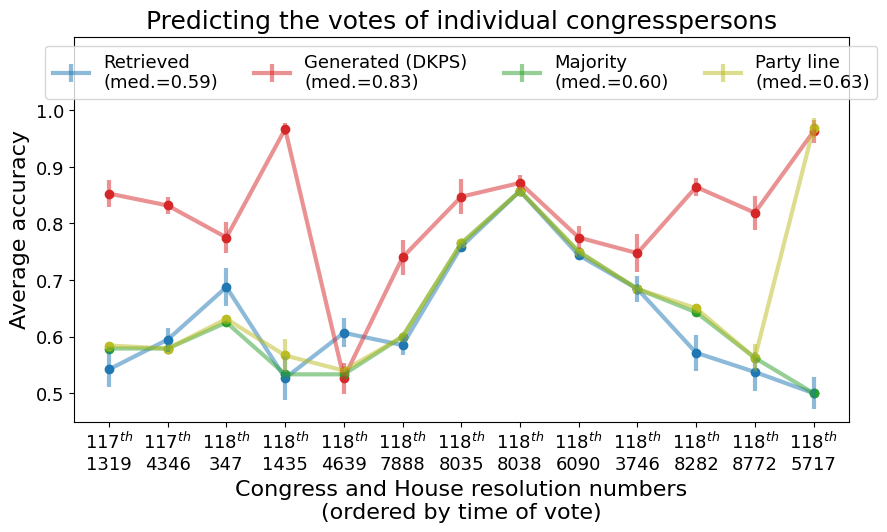

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bill_list = list(cmds_dict.keys())
# bill_list.remove('118-HR 1435')

method_list = list(average_results_dict[bill_list[0]].keys())

bill_labels= []
for bill in bill_list:
    if bill == '118-HR 1435':
        bill_labels.append(r'118$^{th}$'+'\n1435')
        continue
    split = bill.split('-')
    bill_labels.append(f'{split[0]}' + r'$^{th}$' + '\n' + split[2])

# markers=['*', '^', 'v']
# bill_to_marker = {bill: markers[i] for i, bill in enumerate(bill_list)}

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:olive']
method_to_color = {method: colors[i] for i, method in enumerate(method_list)}

legend_dict = {
    'retrieved': 'Retrieved', 
    'generated': 'Generated (DKPS)',
    'majority': 'Majority', 
    'party-line': 'Party line'
}

result_by_method = {method: [] for method in method_list}
std_by_method = {method: [] for method in method_list}
for i, bill in enumerate(bill_list):
    for j, (method, avg) in enumerate(average_results_dict[bill].items()):
        if method == 'generated':
            print(bill, avg)
        ax.scatter(i, avg, color=method_to_color[method])
        result_by_method[method].append(avg)
        std_by_method[method].append(std_results_dict[bill][method])
    
for method in result_by_method:
    median = np.median(result_by_method[method])
    ax.errorbar(range(len(bill_list)), result_by_method[method], yerr=std_by_method[method] / np.sqrt(10), color=method_to_color[method], alpha=0.5, lw=3, 
                label=legend_dict[method]+f'\n(med.={median:1.2f})')
    
ax.set_xticks(range(len(bill_list)), labels=bill_labels)
ax.set_xlabel('Congress and House resolution numbers\n(ordered by time of vote)', fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average accuracy', fontsize=16)
ax.set_title('Predicting the votes of individual congresspersons', fontsize=18)
# ax.set_xlim(-.05, 2.05)
ax.set_ylim(0.45, 1.13)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.legend(fontsize=13, loc='upper center', ncols=4)
plt.savefig('inference_ordered_by_time_of_vote.pdf', bbox_inches='tight')

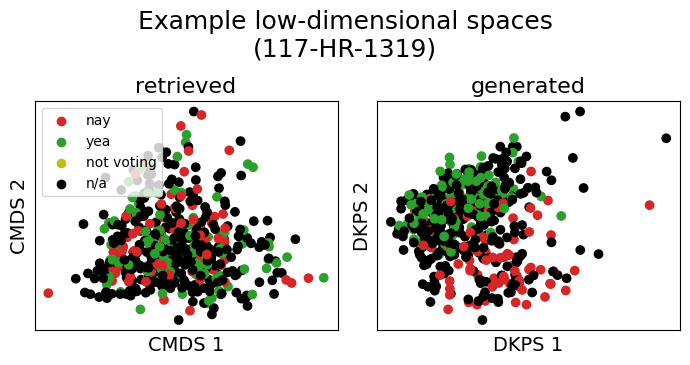

In [34]:
fig, axs = plt.subplots(1,2, figsize=(7, 3.75))
bill='117-HR-1319'

vote_list = vote_by_bill[bill]

cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

axs[0].scatter(cmds_retrieved[:, 0], cmds_retrieved[:, 1], c=[vote_color_dict[p] for p in vote_list])
axs[0].set_title('retrieved', fontsize=16)

axs[1].scatter(cmds_generated[:, 0], cmds_generated[:, 1], c=[vote_color_dict[p] for p in vote_list])
axs[1].set_title('generated', fontsize=16)

for ax in axs:
    ax.tick_params(labelsize=12)
    
    ax.set_xticks([])
    ax.set_yticks([])
        
axs[0].set_xlabel('CMDS 1', fontsize=14)
axs[0].set_ylabel('CMDS 2', fontsize=14)

axs[1].set_xlabel('DKPS 1', fontsize=14)
axs[1].set_ylabel('DKPS 2', fontsize=14)

fig.suptitle(f'Example low-dimensional spaces\n({bill})', y=0.96, fontsize=18)
    
xlim, ylim = axs[0].get_xlim(), axs[0].get_ylim()
for vote, color in vote_color_dict.items():
    axs[0].scatter(-10000, -10000, c=color, label=vote)
axs[0].set_xlim(*xlim)
axs[0].set_ylim(*ylim)

axs[0].legend(loc='upper left')
    
plt.tight_layout()
plt.savefig('example_dkps.pdf', bbox_inches='tight')

In [32]:
from scipy.stats import wilcoxon

best_not_generated = []
for i in range(len(bill_list)):
    best = -1
    for method in result_by_method:
        if method =='generated':
            continue
            
        if result_by_method[method][i] > best:
            best=result_by_method[method][i]
    best_not_generated.append(best)
    
best_not_generated = np.array(best_not_generated)
generated = np.array(result_by_method['generated'])
T, p = wilcoxon(best_not_generated, generated)
print(T,p)

print((generated - best_not_generated) / best_not_generated)

np.mean((generated - best_not_generated) / best_not_generated)

6.0 0.00341796875
[ 0.45945946  0.39823009  0.12727273  0.70588235 -0.13186813  0.23333333
  0.10769231  0.01666667  0.03333333  0.09230769  0.32967033  0.45555556
 -0.00645161]


0.21700646938129223